# 多模态微调入门

## 目标
使用UCSC-VLAA/MedTrinity-25M数据集微调，Qwen2.5-VL-3B-Instruct模型，学会医学ct图片分析能力

## 参考
https://www.cnblogs.com/BUAADreamer/p/18223670
https://17aitech.com/?p=33382

## 准备数据集
使用UCSC-VLAA/MedTrinity-25M数据集

### 下载数据集

In [1]:
from modelscope.msdatasets import MsDataset

# 下载 demo 子集
ds = MsDataset.load(
    'AI-ModelScope/MedTrinity-25M',
    subset_name='25M_demo',  # 指定子集名称
    cache_dir='/root/autodl-tmp/modelscope/dadasets/25M_demo'
)

print(f"数据集大小: {len(dataset)}")



/root/miniconda3/envs/llama_factory/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


数据集大小: 1


### 预览数据集

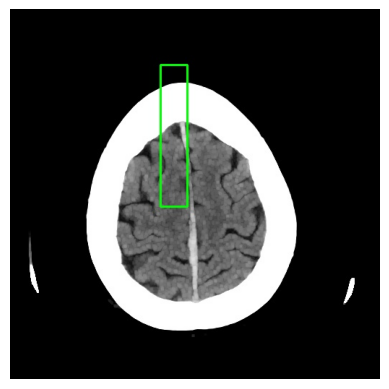

In [7]:
# 可视化image内容
from PIL import Image
import matplotlib.pyplot as plt

image = ds['train'][0]['image']  # 获取第一张图像

plt.imshow(image)
plt.axis('off')  # 不显示坐标轴
plt.show()

### 转换成LLama Factory数据格式

In [11]:
from datasets import load_dataset
import os
import json
from PIL import Image
from tqdm import tqdm

def save_images_and_json(ds, output_dir="mllm_data"):
    """
    将数据集中的图像和对应的 JSON 信息保存到指定目录。

    参数:
    ds: 数据集对象，包含图像和标题。
    output_dir: 输出目录，默认为 "mllm_data"。
    """
    # 创建输出目录
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # 创建一个列表来存储所有的消息和图像信息
    all_data = []

    images_dir = f"{output_dir}/images"
    if not os.path.exists(images_dir):
        os.makedirs(images_dir)

    # 遍历数据集中的每个项目
    for item in tqdm(ds, desc="Saving images"):
        img_path = f"{output_dir}/{item['id']}.jpg"  # 图像保存路径
        image = item["image"]  # 假设这里是一个 PIL 图像对象

        # 将图像对象保存为文件
        image.save(img_path)  # 使用 PIL 的 save 方法

        # 添加消息和图像信息到列表中
        all_data.append(
            {
                "messages": [
                    {
                        "content": "<image>图片中的诊断结果是怎样?",
                        "role": "user",
                    },
                    {
                        "content": item["caption"],  # 从数据集中获取的标题
                        "role": "assistant",
                    },
                ],
                "images": [img_path],  # 图像文件路径
            }
        )

    # 创建 JSON 文件
    json_file_path = f"{images_dir}/mllm_data.json"
    with open(json_file_path, "w", encoding='utf-8') as f:
        json.dump(all_data, f, ensure_ascii=False)  # 确保中文字符正常显示


# 保存数据集中的图像和 JSON 信息
#save_images_and_json(ds['train'], '/root/autodl-tmp/llamaFactory/datasets/MedTrinity-25M')

subset = ds['train'].select(range(10000))
save_images_and_json(subset, "/root/autodl-tmp/llamaFactory/datasets/MedTrinity-25M-debug-1000")

Saving images: 100%|██████████| 10000/10000 [00:19<00:00, 500.99it/s]


### 数据集注册到LLaMaFactory data
修改 LLaMaFactory data目录下的dataset_info.json，增加自定义数据集
/root/LLaMA-Factory/data
``` json
"mllm_med": {
    "file_name": "/root/autodl-tmp/llamaFactory/datasets/MedTrinity-25Mmllm_data.json",
    "formatting": "sharegpt",
    "columns": {
      "messages": "messages",
      "images": "images"
    },
    "tags": {
      "role_tag": "role",
      "content_tag": "content",
      "user_tag": "user",
      "assistant_tag": "assistant"
    }
  },
```

## 加载原始模型
使用Lamma-Factory， 通过modescope下载Qwen2.5-VL-3B-Instruct模型


## 训练
详见 [1.自我认知的训练部分](../1.自我认知/自我认知.ipynb#训练)

## 导出模型
详见 [1.自我认知的合并训练模型部分](../1.自我认知/自我认知.ipynb#合并训练模型)

## 验证效果
- 旧模型

模型能够识别到这是一个CT图像，显示了大概的位置以及相应的器官，但是并不能给出是否存在诊断结果

<img src="images/oldModel.jpg" height="300">

- 微调模型

加载模型并上传之前的CT图片提问同样的问题，可以看到，经过微调后的模型，可以给出具体区域存在的可能异常问题

<img src="images/newModel.jpg" height="300">
